# 7. Advanced simulation: Population fitting and subcatchment aggregation
The examples up to this point have focused on demonstrating the different features an object types within pySIMDEUM using a small collection of houses at most. However, in practice, pySIMDEUM is likely to be used to simulate large number of houses at once and built a representation of water usage, and/or discharge of wastewater into the sewer network.

We will cover two scenarios here:

1) A manual way, simulating multiple houses using demographic stats from your config files.
2) Simulate multiple houses using `build_multi_hh()` method in the api if the occupancy type of a household is already known.
3) A more advanced method in which we use census population counts and boundaries to fit occupancy type to specific house locations, and then simulate based on these occupancy types. A further step of using subcatchment boundaries to aggregate household wastewater profiles is also included.

## 1) Manual method: config file demographic stats

In other examples, you will notice that we have used the `built_house()` method to generate a house, we can use a similar structure of code to achieve this for multiple houses.


In [1]:
import pysimdeum
from pysimdeum.core.house import Property
from pysimdeum.core.statistics import Statistics

In [2]:
houses = []
number_of_houses = 3 

for _i in range(number_of_houses):
    stats = Statistics()
    prop = Property(statistics=stats)
    house = prop.built_house()
    house.populate_house()
    house.furnish_house()
    for user in house.users:
        user.compute_presence(statistics=stats)
    house.simulate()
    houses.append(house)

houses

/Users/val.ismaili/DAA/pysimdeum/pysimdeum/utils/patterns.py:184: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  s.iloc[start:end] = intensity
/Users/val.ismaili/DAA/pysimdeum/pysimdeum/utils/patterns.py:240: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6723566666666668' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  discharge_pattern.loc[discharge_start:discharge_end - pd.Timedelta(seconds=1)] = discharge_rate # restrict range to not be inclusive of final timstamp as this would result in extra discharge
/Users/val.ismaili/DAA/pysimdeum/pysimdeum/utils/patterns.py:240: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pan

[House:
 	id	=	a1e9d4c1-ef07-46a9-982e-2fd0bff0e954
 	type	=	two_person
 	user	=	2
 	appliances	=	['WcNew', 'Bathtub', 'BathroomTap', 'Dishwasher', 'KitchenTap', 'OutsideTap', 'FancyShower', 'WashingMachine'],
 House:
 	id	=	a1e9d4c1-ef07-46a9-982e-2fd0bff0e954
 	type	=	family
 	user	=	3
 	appliances	=	['WcNewSave', 'BathroomTap', 'Dishwasher', 'KitchenTap', 'OutsideTap', 'NormalShower', 'WashingMachine'],
 House:
 	id	=	a1e9d4c1-ef07-46a9-982e-2fd0bff0e954
 	type	=	family
 	user	=	4
 	appliances	=	['WcNormal', 'Bathtub', 'BathroomTap', 'Dishwasher', 'KitchenTap', 'OutsideTap', 'FancyShower', 'WashingMachine']]

You can access each `House` object from the `houses` list as normal and view plot or write files.

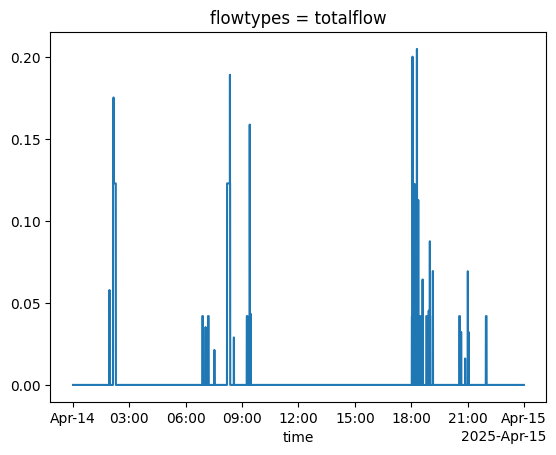

In [3]:
houses[0].consumption.sum(["user","enduse","patterns"]).sel(flowtypes="totalflow").plot()

## 2) `build_multi_hh()` method

This method assumes you have a list of houses with unique ids and occupancy type pre-assigned. In our case we will just generate a demo dictionary of what this input might look like so the expected input format is clear.


In [4]:
household_dict = {
    "hh_1": "one_person",
    "hh_2": "two_person",
    "hh_3": "family"
}

household_dict

{'hh_1': 'one_person', 'hh_2': 'two_person', 'hh_3': 'family'}

You can provide the regular inputs on simulation duration, inclusion of discharge and use of spillover feature. Notice the house ids and occupancy type being carried through the simulation into the `House` objects.

In [5]:
houses = pysimdeum.build_multi_hh(
    household_data=household_dict,
    duration='1 day',
    country='UK',
    simulate_discharge=False,
    spillover=False
    )

houses

/Users/val.ismaili/DAA/pysimdeum/pysimdeum/utils/patterns.py:184: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  s.iloc[start:end] = intensity
/Users/val.ismaili/DAA/pysimdeum/pysimdeum/utils/patterns.py:240: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6723566666666668' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  discharge_pattern.loc[discharge_start:discharge_end - pd.Timedelta(seconds=1)] = discharge_rate # restrict range to not be inclusive of final timstamp as this would result in extra discharge
/Users/val.ismaili/DAA/pysimdeum/pysimdeum/utils/patterns.py:240: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pan

{'hh_1': House:
 	id	=	a1e9d4c1-ef07-46a9-982e-2fd0bff0e954
 	type	=	one_person
 	user	=	1
 	appliances	=	['WcNewSave', 'Bathtub', 'BathroomTap', 'Dishwasher', 'KitchenTap', 'FancyShower', 'WashingMachine'],
 'hh_2': House:
 	id	=	a1e9d4c1-ef07-46a9-982e-2fd0bff0e954
 	type	=	two_person
 	user	=	2
 	appliances	=	['WcNormalSave', 'BathroomTap', 'Dishwasher', 'KitchenTap', 'NormalShower', 'WashingMachine'],
 'hh_3': House:
 	id	=	a1e9d4c1-ef07-46a9-982e-2fd0bff0e954
 	type	=	family
 	user	=	5
 	appliances	=	['WcNormalSave', 'BathroomTap', 'Dishwasher', 'KitchenTap', 'FancyShower', 'WashingMachine']}

## 3) `Population` method: population fitting and subcatchment aggregation

This final method provides a way of feeding in granular census population counts for boundaries within your study area. In the UK, this might look like providing output area boundaries and their population counts as well as house locations. An extra file representing subcatchments is included to help aggregate household wastewater profiles together.

This method is supported by the `DataPrep` class and `spatial_config.toml` which together help prepare the various input files needed for this method into a standardised format that works with the `Population` method.

Data files needed and their expected columns are:
* Census boundaries file (e.g. `.geojson`)
    * census boundary ids
    * geometry
* Census population count (with ids matching boundaries file)
    * census boundary ids
    * population count
* House location points (unique ids)
    * ids
    * building type (assuming file includes mix of resi and non-resi)
* Subcatchment boundaries (e.g. `.geojson`)
    * ids
    * geometry

The `DataPrep` class and `spatial_config.toml` essentially help map column ids from your raw dataset to the expected inputs for the `Population` method. We can read in the config file to just understand the different sections. The first section `dataset` is the file path to each of your respective files.

In [6]:
import os
import toml
from pysimdeum.data import DATA_DIR
from pysimdeum.core.population import DataPrep, Population
import folium

spatial_config = toml.load(os.path.join(DATA_DIR, "UK", 'spatial_config.toml'))

In [7]:
spatial_config['datasets']

{'subcatchments': '/Users/val.ismaili/DAA/pysimdeum/examples/data/subcatchments.geojson',
 'boundaries': '/Users/val.ismaili/DAA/pysimdeum/examples/data/oa.geojson',
 'boundaries_pop': '/Users/val.ismaili/DAA/pysimdeum/examples/data/oa_population.csv',
 'houses': '/Users/val.ismaili/DAA/pysimdeum/examples/data/houses.geojson'}

The user will need to map their file specific columns to the expected column names. Essentially, the key (left) is the expected name (do not change that), and the corresponding value (right) is the file specific name. In the example below, my subcatchments file has a column called `subcatchme` that is being mapped to `subcatchment_id`.

In [8]:
spatial_config['columns']

{'subcatchments': {'geometry': 'geometry', 'subcatchment_id': 'subcatchme'},
 'boundaries': {'geometry': 'geometry', 'boundary_id': 'OA21CD'},
 'boundaries_pop': {'boundary_id_code': 'OA 2021 Code', 'population': 'Total'},
 'houses': {'geometry': 'geometry',
  'house_id': 'TOID',
  'function': 'BaseFuncti'}}

`DataPrep` prepares the input data into a generalised format based on the mapping instructions from `spatial_config.toml`

In [9]:
data_prep = DataPrep(country='UK')

Initialising a `Population` class with the `DataPrep` instance as an input, combined with the usual arguments when simulating houses will set off a series of actions that assign occupancy types to household locations that fit against census population counts for the inputted boundaries. An additional argument, `sample` is used to run the process for 10 randomly sampled houses contained within the study area.

In [10]:
pop = Population(datasets = data_prep.datasets, sample=True, country='UK', simulate_discharge=True, spillover=False)

/Users/val.ismaili/DAA/pysimdeum/pysimdeum/utils/patterns.py:184: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  s.iloc[start:end] = intensity
/Users/val.ismaili/DAA/pysimdeum/pysimdeum/utils/patterns.py:240: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6723566666666668' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  discharge_pattern.loc[discharge_start:discharge_end - pd.Timedelta(seconds=1)] = discharge_rate # restrict range to not be inclusive of final timstamp as this would result in extra discharge
/Users/val.ismaili/DAA/pysimdeum/pysimdeum/utils/patterns.py:240: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pan

Now contained with `pop` (`Population` instance) is `house_instances` which is a dictionary of house ids and their `House` instance containing the usual information of a house including the simulation objects.

In [11]:
pop.houses_instances

{'hh32': House:
 	id	=	a1e9d4c1-ef07-46a9-982e-2fd0bff0e954
 	type	=	one_person
 	user	=	1
 	appliances	=	['WcNewSave', 'BathroomTap', 'KitchenTap', 'FancyShower', 'WashingMachine'],
 'hh98': House:
 	id	=	a1e9d4c1-ef07-46a9-982e-2fd0bff0e954
 	type	=	one_person
 	user	=	1
 	appliances	=	['WcNewSave', 'BathroomTap', 'KitchenTap', 'OutsideTap', 'FancyShower', 'WashingMachine'],
 'hh196': House:
 	id	=	a1e9d4c1-ef07-46a9-982e-2fd0bff0e954
 	type	=	one_person
 	user	=	1
 	appliances	=	['WcNew', 'Bathtub', 'BathroomTap', 'Dishwasher', 'KitchenTap', 'OutsideTap', 'FancyShower', 'WashingMachine'],
 'hh174': House:
 	id	=	a1e9d4c1-ef07-46a9-982e-2fd0bff0e954
 	type	=	one_person
 	user	=	1
 	appliances	=	['WcNormal', 'BathroomTap', 'KitchenTap', 'FancyShower', 'WashingMachine'],
 'hh77': House:
 	id	=	a1e9d4c1-ef07-46a9-982e-2fd0bff0e954
 	type	=	two_person
 	user	=	2
 	appliances	=	['WcNormalSave', 'BathroomTap', 'Dishwasher', 'KitchenTap', 'OutsideTap', 'FancyShower', 'WashingMachine'],
 'hh

You can also access a dictionary of the subcatchments and the houses contained within that area. This is used to then aggregate household wastewater profiles to subcatchment level.

In [12]:
pop.subcatchment_houses

{'SO40511701.1': ['hh188'],
 'SO40511750': ['hh154', 'hh246'],
 'SO40511801': ['hh165', 'hh174', 'hh244'],
 'SO40511801.1': ['hh163'],
 'SO40512602': ['hh168', 'hh191', 'hh205'],
 'SO40512701': ['hh179'],
 'SO40512704': ['hh148', 'hh214'],
 'SO40512801': ['hh185', 'hh186', 'hh211', 'hh257'],
 'SO40513702': ['hh138'],
 'SO40513802': ['hh151', 'hh234'],
 'SO40514301': ['hh71', 'hh77'],
 'SO40514403': ['hh4', 'hh22'],
 'SO40514503': ['hh23', 'hh25', 'hh76'],
 'SO40514704': ['hh248', 'hh251'],
 'SO40514705': ['hh146', 'hh203', 'hh228', 'hh255', 'hh260'],
 'SO40514801': ['hh183', 'hh196', 'hh245', 'hh259'],
 'SO40515201': ['hh16', 'hh34'],
 'SO40515502': ['hh6',
  'hh27',
  'hh30',
  'hh48',
  'hh65',
  'hh99',
  'hh106',
  'hh127'],
 'SO40515601!': ['hh141', 'hh142', 'hh206', 'hh215', 'hh252'],
 'SO40515603.1': ['hh128'],
 'SO40516401': ['hh2',
  'hh31',
  'hh32',
  'hh39',
  'hh43',
  'hh44',
  'hh53',
  'hh59',
  'hh85',
  'hh91',
  'hh93',
  'hh112',
  'hh113',
  'hh123'],
 'SO40517304'

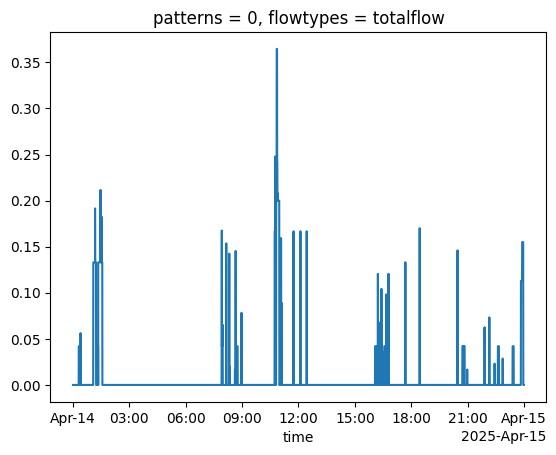

In [15]:
pop.subcatchment_profiles['SO40514801'].plot()

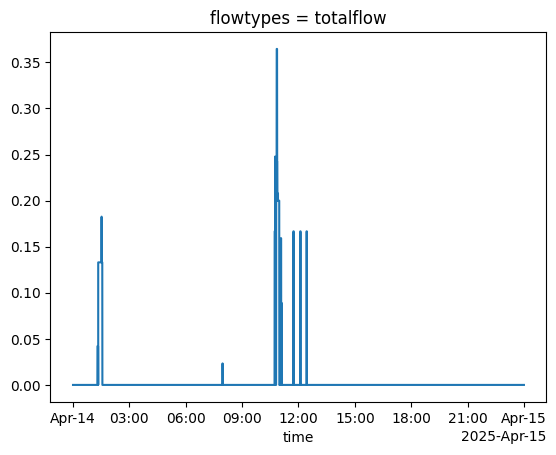

In [16]:
pop.houses_instances['hh196'].consumption.sum(['enduse', 'user']).sel(flowtypes='totalflow').mean(['patterns']).plot()

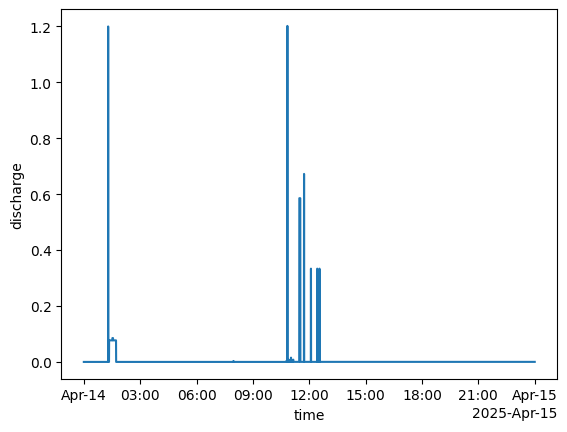

In [17]:
pop.houses_instances['hh196'].discharge.discharge.sum(['enduse', 'user', 'dischargetypes']).mean(['patterns']).plot()

All the objects are still accessible. Here we can view the subcatchments and the houses contained within them, categorised by the occupancy type.

In [18]:
m = pop.subcatchments.explore(name='houses')

pop.houses.explore(m=m, name='houses', column='occupancy_type')

folium.LayerControl().add_to(m)

m